In [1]:
import mne
from mne_bids import BIDSPath, read_raw_bids
from bids import BIDSLayout
from mne_bids import config
config.ALLOWED_FILENAME_SUFFIX += ["raw"]
from matplotlib.figure import Figure
from scipy.stats import ttest_ind
import pandas
import numpy as np

# Dataset Location
Change this to your preferred location

In [ ]:
bids_root = "/path/to/dataset"

# ERPs Configurations

In [3]:
trigger_latency = 0.06
erp_conf = {
    "LPP": {"ch": ["CPz", "Cz", "Pz"], "tmin":0.4, "tmax":0.6},
    "N170": {"ch": ["P7","P8"], "tmin":0.13, "tmax":0.2},
    "N100": {"ch": ["F4", "FC4", "F3", "FC3"], "tmin":0.07, "tmax":0.13},
    "P100": {"ch": ["Oz", "O1", "O2"], "tmin":0.07, "tmax":0.16},
    "N200": {"ch": ["Fz", "FCz", "Cz", "CPz", "Pz"], "tmin":0.2, "tmax":0.35},
    "P200": {"ch": ["Fz", "FCz", "Cz", "CPz", "Pz"], "tmin":0.15, "tmax":0.23},
    "P300": {"ch": ["Fz", "FCz", "Cz", "CPz", "Pz"], "tmin":0.27, "tmax":0.4},
    "N400": {"ch": ["CPz", "CP4", "CP3", "Pz", "P4", "P3"], "tmin":0.35, "tmax":0.55},
    "P600": {"ch": ["P3", "Pz", "P4"], "tmin":0.5, "tmax":0.75},
    "ELAN": {"ch": ["F3","F7"], "tmin":0.12, "tmax":0.22},
    "LAN": {"ch": ["F3","F7"], "tmin":0.3, "tmax":0.45}
}

In [4]:
def load_clean_epochs(erp_name):
    task='UV'
    data_root = f"{bids_root}/derivatives/{erp_name}"
    layout = BIDSLayout(bids_root)

    subjects = layout.get_subjects()
    runs = layout.get_runs()

    raws = [mne.concatenate_raws([read_raw_bids(BIDSPath(subject=subject, task=task, run=run, datatype="eeg", processing="clean", suffix="raw", extension=".fif", root=data_root)) for run in runs]) for subject in subjects];

    reject_criteria = dict(eeg=100e-6)
    epochs_sets = [mne.Epochs(raw,preload=True, tmin=-0.2+trigger_latency, tmax=1+trigger_latency, baseline=(-0.2+trigger_latency, 0+trigger_latency)).drop_bad(reject=reject_criteria).shift_time(-trigger_latency, relative=True) for raw in raws]

    if "reference" in erp_conf[erp_name]:
        epochs_sets = [e.set_eeg_reference(erp_conf[erp_name]["reference"]) for e in epochs_sets]

    return epochs_sets

In [5]:
def plot_evoked_potentials(erp_name, epochs_sets):

    evokeds = dict(eerie=[epochs["eerie"].average() for epochs in epochs_sets if len(list(set(erp_conf[erp_name]['ch']) & set(epochs.info["bads"]))) == 0], 
               non_eerie = [epochs["not_eerie"].average()for epochs in epochs_sets if len(list(set(erp_conf[erp_name]['ch']) & set(epochs.info["bads"]))) == 0])

    return mne.viz.plot_compare_evokeds(
        evokeds,
        title = f"{erp_name}: {', '.join(erp_conf[erp_name]['ch'])}",
        picks=erp_conf[erp_name]['ch'],
        combine='mean',
        legend='upper left',
        show_sensors='upper right',
        vlines=[erp_conf[erp_name]["tmin"],erp_conf[erp_name]["tmax"]],
    )[0]

In [10]:
def test_peak_amplitude(erp_name, epochs_set, alternative=None):
    if alternative is None:
        alternative = 'less' if erp_name.startswith('N') else 'greater'
    mode = 'neg' if erp_name.startswith('N') else 'pos'

    roi = {"ROI": mne.pick_channels(epochs_set[0].info["ch_names"], include=erp_conf[erp_name]['ch'])}
    eerie = [mne.channels.combine_channels(subject["eerie"], roi, method="mean", drop_bad=True).average().get_peak(ch_type="eeg", tmin=erp_conf[erp_name]["tmin"], tmax=erp_conf[erp_name]["tmax"], mode=mode, strict=False, return_amplitude=True)[2] for subject in epochs_set]
    non_eerie = [mne.channels.combine_channels(subject["not_eerie"], roi, method="mean", drop_bad=True).average().get_peak(ch_type="eeg", tmin=erp_conf[erp_name]["tmin"], tmax=erp_conf[erp_name]["tmax"], mode=mode, strict=False, return_amplitude=True)[2] for subject in epochs_set]
    
    stats, pvalue = ttest_ind(eerie,non_eerie, alternative=alternative, nan_policy="omit")
    return dict(erp=erp_name, eerie_peak=np.nanmean(eerie)*1000000, non_eerie_peak=np.nanmean(non_eerie)*1000000, p=pvalue)

# Data Loading

In [7]:
%%capture
erp_epoch_sets = {key:load_clean_epochs(key) for key in erp_conf.keys()}

# Statistical Analysis

In [11]:
%%capture
test_results = pandas.DataFrame([test_peak_amplitude(key,value) for key,value in erp_epoch_sets.items()])
reject, pvalue_corrected = mne.stats.fdr_correction(test_results["p"].to_list())
test_results.columns = ["ERP", "Eeerie", "Non Eeerie", "p Value"]
test_results["Adjusted p Value"] = pvalue_corrected
test_results["Reject"] = reject

In [12]:
test_results

,ERP,Eeerie,Non Eeerie,p Value,Adjusted p Value,Reject
0,LPP,10.091485,6.522733,0.000014,0.000156,True
1,N170,-5.098284,-4.855020,0.400840,0.677705,False
2,N100,-1.621246,-1.745708,0.625635,0.707539,False
3,P100,3.216747,3.091774,0.406670,0.677705,False
4,N200,0.871148,0.549999,0.643217,0.707539,False
5,P200,7.048377,7.031947,0.492876,0.677705,False
6,P300,5.998118,5.027688,0.115620,0.317954,False
7,N400,3.240716,2.707575,0.767877,0.767877,False
8,P600,8.813084,5.589823,0.000045,0.000247,True
9,ELAN,5.799451,5.690180,0.439631,0.677705,False


## Latex Output

In [13]:
print(test_results.to_latex(index=False,caption="T-test results for ERPs peak comparison between eerie and non eerie conditions. The p value is adjusetd to using False Discovery Rate correction.", label="tab:group_erp_peak_test"))

\begin{table}
\caption{T-test results for ERPs peak comparison between eerie and non eerie conditions. The p value is adjusetd to using False Discovery Rate correction.}
\label{tab:group_erp_peak_test}
\begin{tabular}{lrrrrr}
\toprule
ERP & Eeerie & Non Eeerie & p Value & Adjusted p Value & Reject \\
\midrule
LPP & 10.091485 & 6.522733 & 0.000014 & 0.000156 & True \\
N170 & -5.098284 & -4.855020 & 0.400840 & 0.677705 & False \\
N100 & -1.621246 & -1.745708 & 0.625635 & 0.707539 & False \\
P100 & 3.216747 & 3.091774 & 0.406670 & 0.677705 & False \\
N200 & 0.871148 & 0.549999 & 0.643217 & 0.707539 & False \\
P200 & 7.048377 & 7.031947 & 0.492876 & 0.677705 & False \\
P300 & 5.998118 & 5.027688 & 0.115620 & 0.317954 & False \\
N400 & 3.240716 & 2.707575 & 0.767877 & 0.767877 & False \\
P600 & 8.813084 & 5.589823 & 0.000045 & 0.000247 & True \\
ELAN & 5.799451 & 5.690180 & 0.439631 & 0.677705 & False \\
LAN & 4.188354 & 3.311964 & 0.099496 & 0.317954 & False \\
\bottomrule
\end{tabular}
\e

# Visual Analysis

combining channels using "mean"
combining channels using "mean"


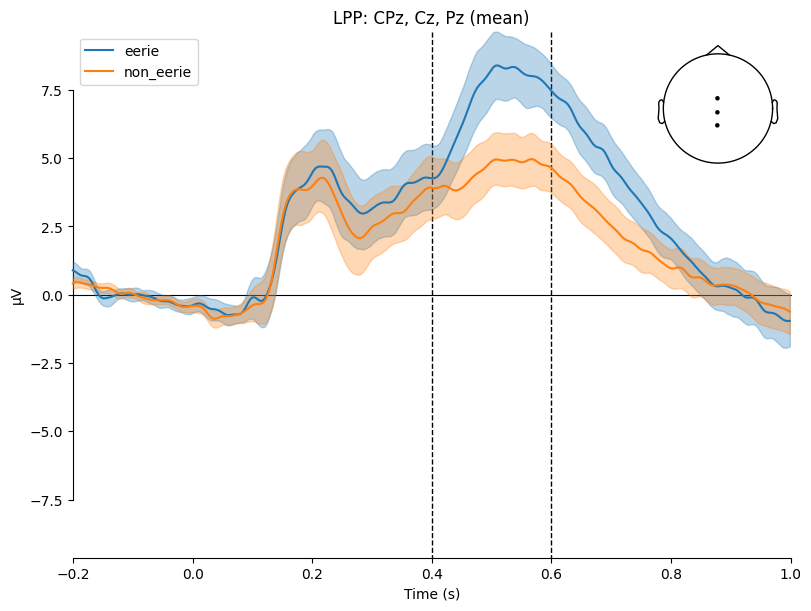

combining channels using "mean"
combining channels using "mean"


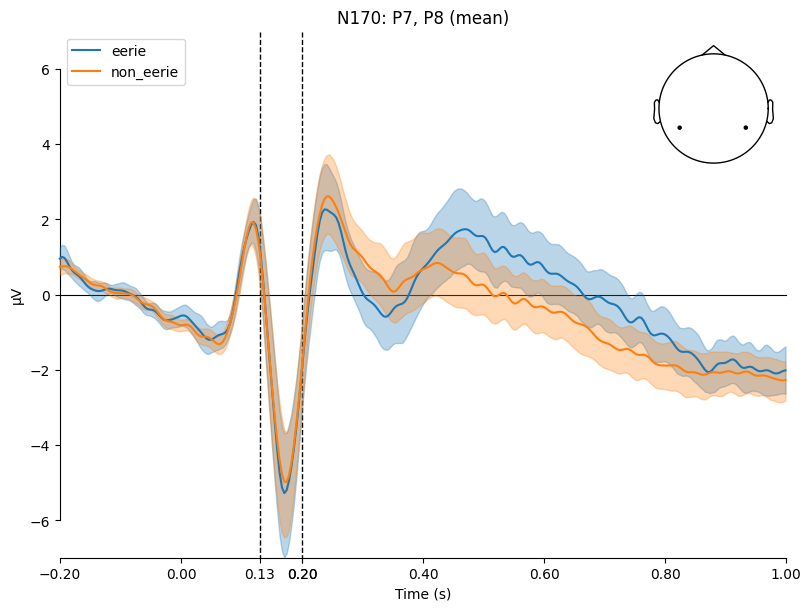

combining channels using "mean"
combining channels using "mean"


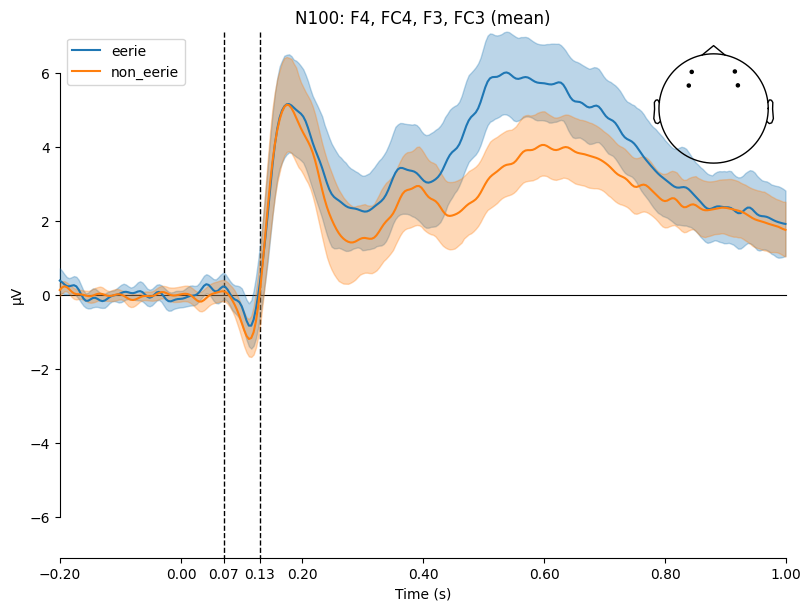

combining channels using "mean"
combining channels using "mean"


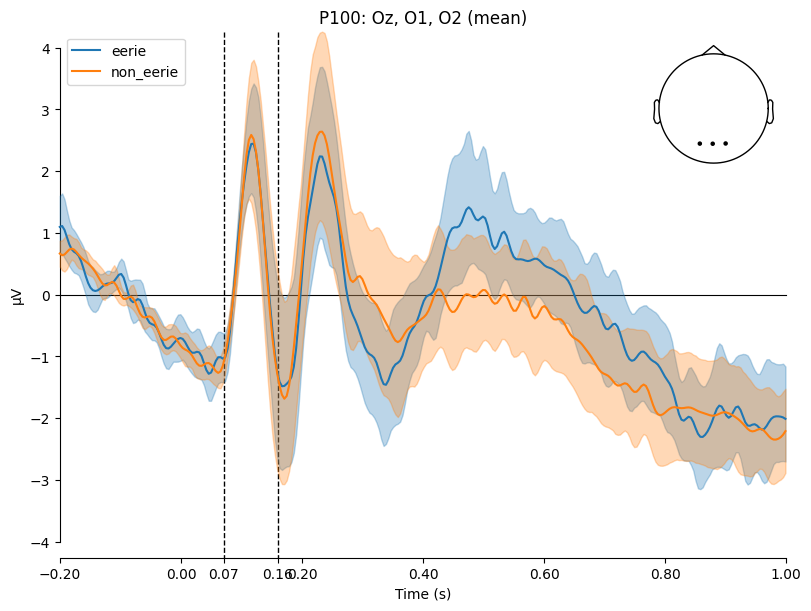

combining channels using "mean"
combining channels using "mean"


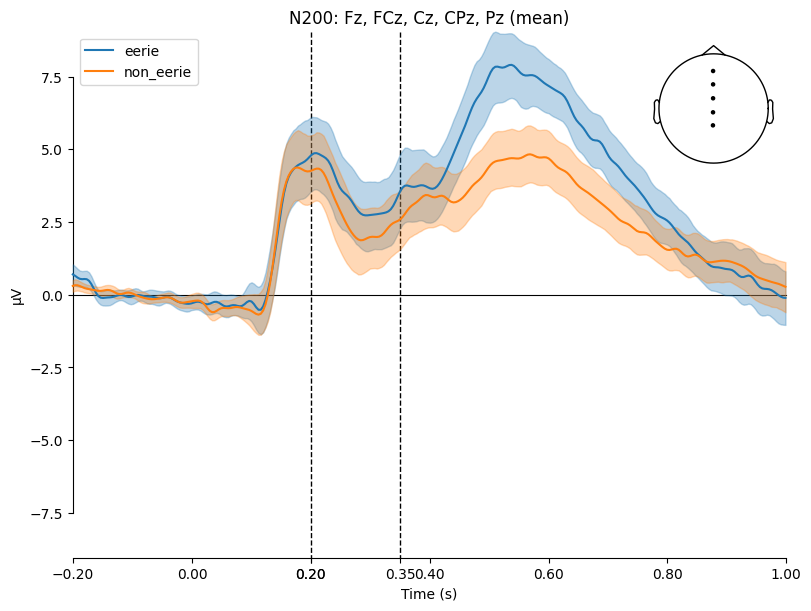

combining channels using "mean"
combining channels using "mean"


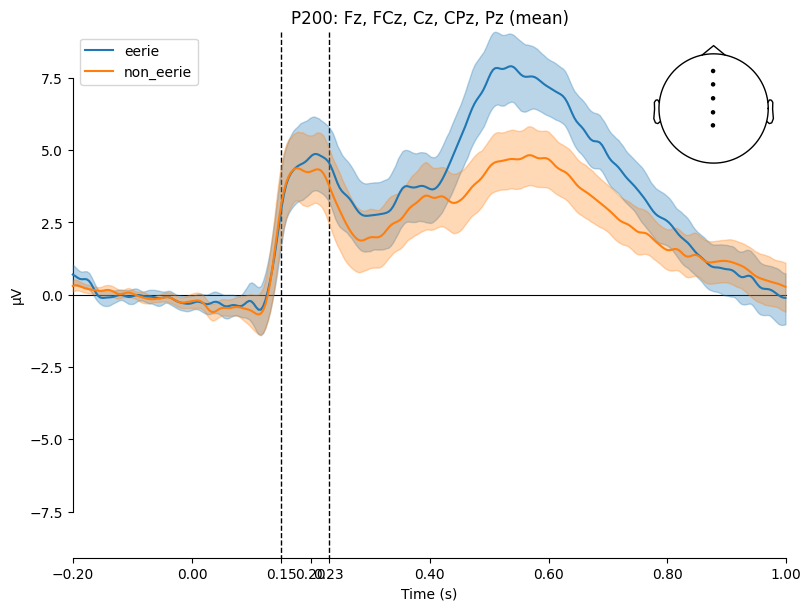

combining channels using "mean"
combining channels using "mean"


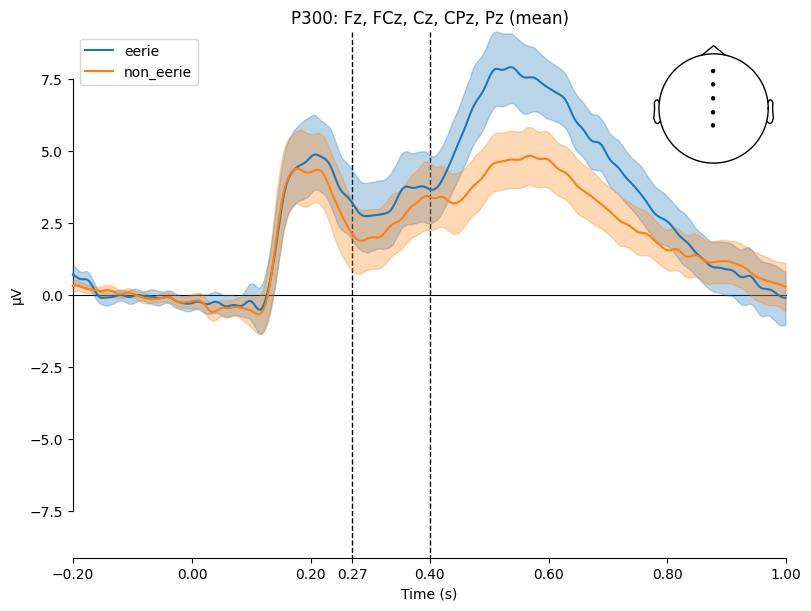

combining channels using "mean"
combining channels using "mean"


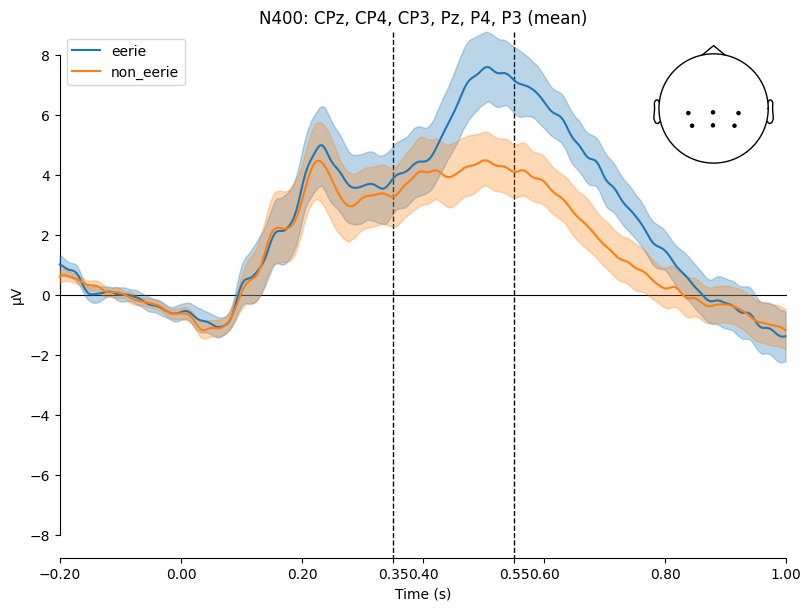

combining channels using "mean"
combining channels using "mean"


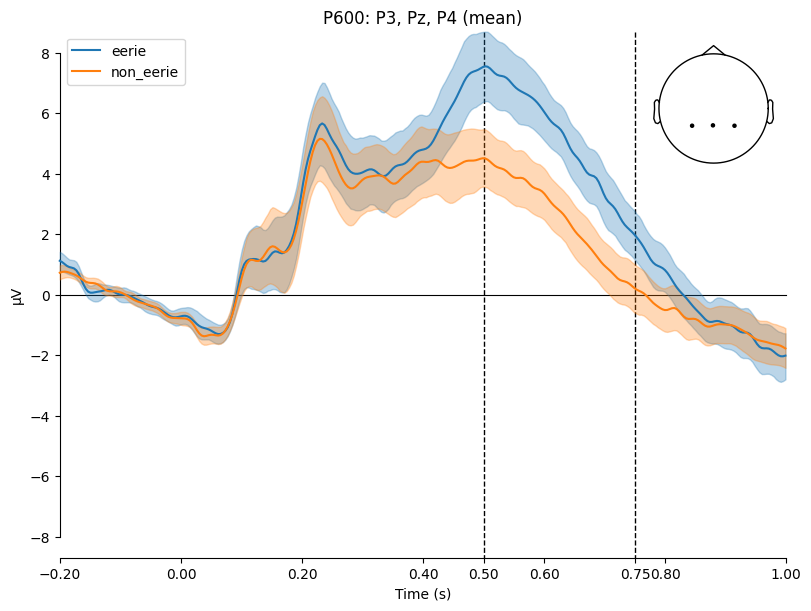

combining channels using "mean"
combining channels using "mean"


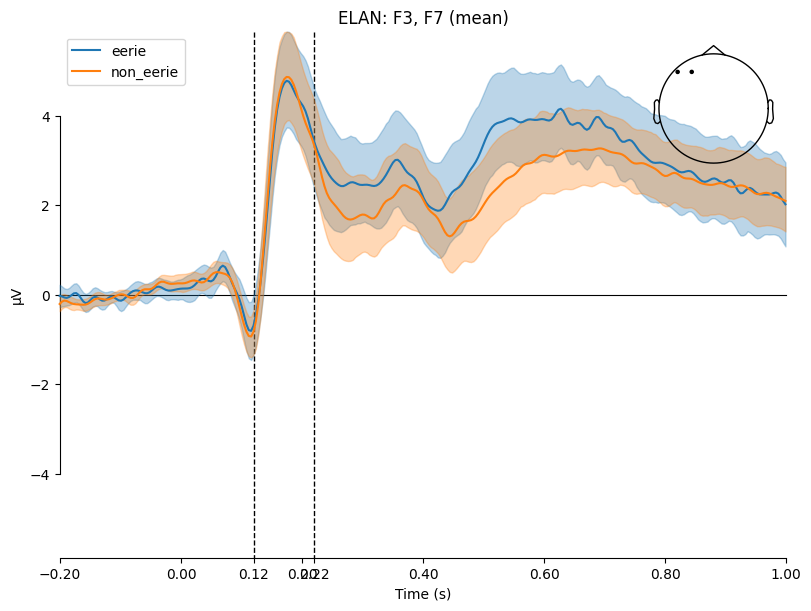

combining channels using "mean"
combining channels using "mean"


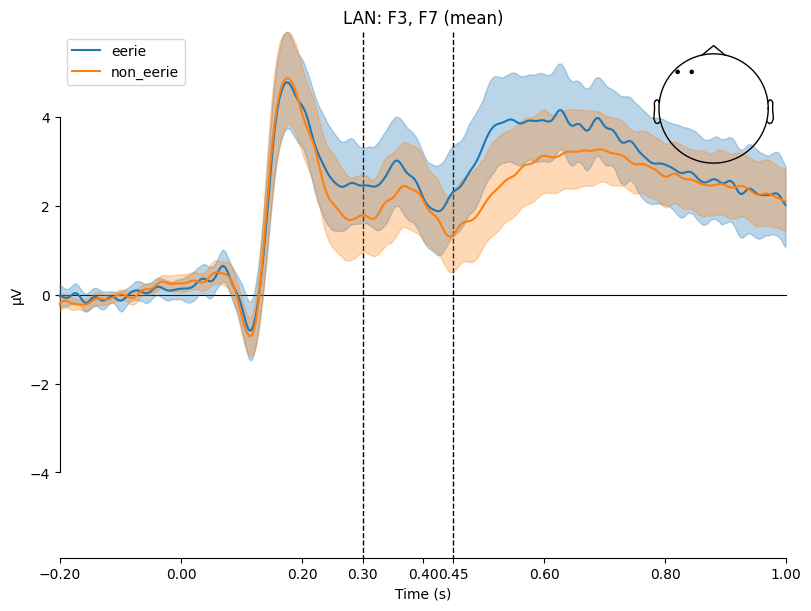

In [14]:
for key,value in erp_epoch_sets.items():
    fig = plot_evoked_potentials(key,value)
    fig.savefig(fname=f"figures/group_{key}.svg",format="svg")